In [ ]:
#| default_exp data_prep

In [40]:
#| export
from pathlib import Path
from typing import Union, List, Dict, Any, Optional, Callable, Type, Tuple
from fastcore.all import * 
from fastcore.test import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import matplotlib as mpl


In [41]:
DPI =mpl.rcParams['figure.dpi']
mpl.rcParams['image.cmap'] = 'gray'

In [20]:
#| export
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from torch.optim import AdamW
import monai

In [8]:
#| export
from transformers import SamProcessor
# we will start with base
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

In [21]:
#| hide
im_path = Path(Path.cwd().parent/'train_images')
msk_path = Path(Path.cwd().parent/'train_masks')
images = [Image.fromarray(cv2.imread(i.as_posix(), cv2.IMREAD_GRAYSCALE)) for i in im_path.ls(file_exts='.png')]
masks = [Image.fromarray(cv2.imread(i.as_posix(), cv2.IMREAD_GRAYSCALE)) for i in msk_path.ls(file_exts='.png')]
dataset_dict = {
    'image':images,
    'label':masks
}
dataset = Dataset.from_dict(dataset_dict)

In [23]:
#| export
def get_dataset(
        im_path:Union[Path,str],
        msk_path:Union[Path, str]
        ):
    "Create a dataset from image and mask path"

    # in case of it is string
    if isinstance(im_path, str):
        im_path = Path(im_path)
        msk_path = Path(msk_path)

    images = [Image.fromarray(cv2.imread(i.as_posix(), cv2.IMREAD_GRAYSCALE)) for i in im_path.ls(file_exts='.png')]
    masks = [Image.fromarray(cv2.imread(i.as_posix(), cv2.IMREAD_GRAYSCALE)) for i in msk_path.ls(file_exts='.png')]
    dataset_dict = {
        'image':images,
        'label':masks
    }
    dataset = Dataset.from_dict(dataset_dict)
    return dataset

    

In [25]:
dataset = get_dataset(
    im_path,
    msk_path

)

In [32]:
len(dataset)

1642

In [38]:
#| export
def show_dataset(dataset):
    idx = np.random.randint(0, len(dataset))
    print(f' dataset index will be visualized: {idx}')
    im_ = dataset[idx]['image']
    msk_ = dataset[idx]['label']
    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5)
    )
    ax[0].imshow(im_)
    ax[1].imshow(msk_)


 dataset index will be visualized: 648


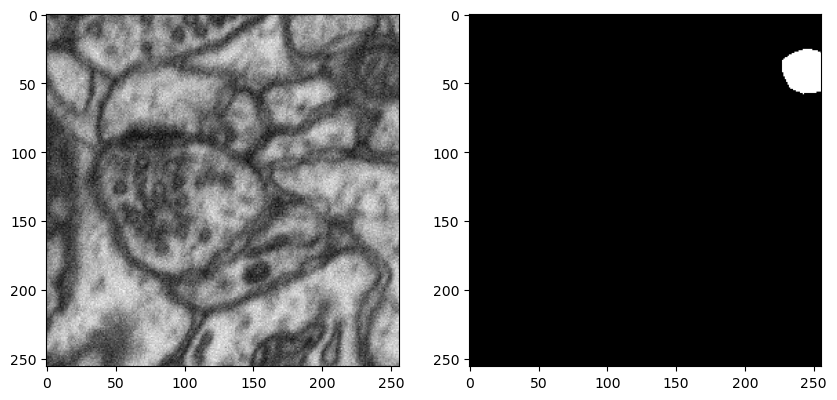

In [48]:
show_dataset(dataset)

In [5]:
#| export
def get_bounding_box(
        ground_truth_map
        ):

    y_, x_ = np.where(ground_truth_map> 0)
    x_min, x_max = np.min(x_), np.max(x_)
    y_min, y_max = np.min(y_), np.max(y_)

    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [7]:
#| export
class SAMDataset(Dataset):
    "Creating dataset for SAM training"

    def __init__(
            self,
            dataset,
            processors
            ):
        self.dataset = dataset
        self.processors = processors

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        mask = np.array(item['label'])
        prompt = get_bounding_box(mask)

        # prepare image and prompt for model
        inputs = self.processors(
                                 image, 
                                 input_boxes=[[prompt]],
                                 return_tensors="pt"
                                 )
        # remove batch dimension created by the processor
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['mask'] = mask
        return inputs

In [49]:
train_ds = SAMDataset(dataset, processor)

In [50]:
example = train_ds[0]
for k,v in example.items():
    print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
mask: (256, 256)


In [51]:
train_dl = DataLoader(
    train_ds, 
    batch_size=2, 
    shuffle=True)

In [52]:

batch = next(iter(train_dl))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
mask torch.Size([2, 256, 256])


In [53]:
#| hide
import nbdev; nbdev.nbdev_export()